In [1]:
import gzip
from collections import defaultdict
import numpy as np
import random
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
def readGz(f):
  for l in gzip.open(f):
    yield eval(l)
    
print "Reading data..."
data = list(readGz('train.json.gz'))
print "Done"

Reading data...
Done


In [73]:
# get user info and item info
user_info = defaultdict(set) # items user has bought
user_cate = defaultdict(set) # category user has bought
item_cate = defaultdict(set)
for d in data:
    u = d['reviewerID']
    i = d['itemID']
    user_info[u].add(i)

In [74]:
for d in data:
    u = d['reviewerID']
    i = d['itemID']
    for cate in d['categories']:
        for c in cate:
            user_cate[u].add(c)
            item_cate[i].add(c)

In [75]:
item_users = defaultdict(set)
for d in data:
    i = d['itemID']
    u = d['reviewerID']
    item_users[i].add(u)

In [76]:
similar_user = defaultdict(set)
for u in user_info:
    for i in user_info[u]:
        for user in item_users[i]:
            if not user == u:
                similar_user[u].add(user)

In [77]:
# get similarity between two users
def get_simi(u1,u2):
    # just use Jaccard similarity: J(A,B) = |A and B| / |A or B|
    a_and_b = 0
    a_or_b = 0
    for cate in user_cate[u1]:
        if cate in user_cate[u2]:
            a_and_b += 1
        else:
            a_or_b += 1
    a_or_b += len(user_cate[u2])
    return a_and_b / (a_or_b * 1.0)

In [78]:
# get similarity between user and  item
def get_simi_ui(u,i):
    # just use Jaccard similarity: J(A,B) = |A and B| / |A or B|
    a_and_b = 0
    a_or_b = 0
    for cate in user_cate[u]:
        if cate in item_cate[i]:
            a_and_b += 1
        else:
            a_or_b += 1
    a_or_b += len(item_cate[i])
    return a_and_b / (a_or_b * 1.0)

In [79]:
import time
t1 = time.ctime()
user_relation = defaultdict(set)
for u1 in user_info:
    for u2 in similar_user[u1]:
        user_relation[u1].add((u2,get_simi(u1,u2)))
t2 = time.ctime()
print str(t1)
print str(t2)

Sun Nov 18 10:09:19 2018
Sun Nov 18 10:10:01 2018


In [83]:
# input: user, item, user_relation,k
def will_purchase(u,i,u_r,k):
    if (u not in user_info) or (i not in item_users):
        return random.randint(0,1)
    # find k closet item, if they has been bought by u, i will bought by u
    friends = []
    for f in u_r[i]:
        friends.append(f)
    friends = sorted(friends, key=lambda x: x[1], reverse=True)
    index = 0
    if k > len(friends):
        k = len(friends)
    while index < k:
        user = friends[index][0]
        if get_simi_ui(user,i) > 0:
            return 1
        index += 1
    return 0

In [84]:
# get test data
test_data = []

for i in range(1000):
    d = random.choice(data)
    test_data.append((d['reviewerID'],d['itemID']))

for i in range(1000):
    while 1:
        d1 = random.choice(data)
        d2 = random.choice(data)
        u = d1['reviewerID']
        i = d2['itemID']
        if u not in item_users[i]:
            test_data.append((u,i))
            break

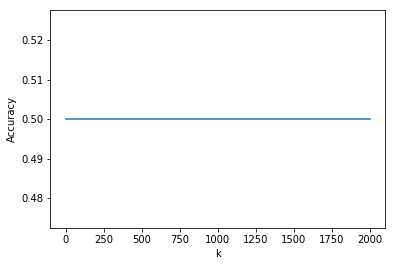

max acc:0.5
k: 1


In [85]:
# find the best k


klist = [1, 10, 50, 100, 200, 500, 1000, 1500, 2000]
accs = []
for k in klist:
    acc = 0
    for d in test_data[:1000]:
        acc += will_purchase(d[0],d[1],user_relation,k)
    for d in test_data[1000:]:
        acc += (1-will_purchase(d[0],d[1],user_relation,k))
    acc /= (len(test_data) * 1.0)
    accs.append(acc)

plt.xlabel("k")
plt.ylabel("Accuracy")
plt.plot(klist, accs)
plt.show()
print "max acc:" + str(max(accs))
print "k: " + str(klist[accs.index(max(accs))])

In [42]:
# get the prediction
predictions = open("/Users/nan/Desktop/assign1_pairs_Purchase.txt", 'w')
for l in open("pairs_Purchase.txt"):
    if l.startswith("reviewerID"):
        #header
        predictions.write(l)
        continue
    u,i = l.strip().split('-')
    res = will_purchase(u,i,user_relation,user_info,10)
    predictions.write(u + '-' + i + ',' + str(res) + '\n')
predictions.close()

In [39]:
n = 2300
for d in user_relation:
    if len(user_relation[d]) < n:
        n = len(user_relation[d])
n

0

In [66]:
get_simi_ui('U844197134','I006212764')

0.0